## Exercise: Differential Quotient Operator and Regularization

Consider the inverse problem of finding $ u $ from $ Ku = f $ with the integral operator
$$
K:L^2([0,1])\to L^2([0,1]),\quad (Ku)(y):=\int_0^y u(x)\,dx.
$$
As an approximation to the Moore–Penrose inverse $ K^\dagger $, define for $ \alpha \in (0,1/2) $ the differential quotient operators
$$
(R_\alpha f)(x) := \frac{1}{\alpha}\begin{cases}
f(x+\alpha) - f(x), & x \in \left[0, \tfrac{1-\alpha}{2}\right[, \\
f(x + \tfrac{\alpha}{2}) - f(x - \tfrac{\alpha}{2}), & x \in \left[\tfrac{1-\alpha}{2}, \tfrac{1+\alpha}{2}\right[, \\
f(x) - f(x - \alpha), & x \in \left[\tfrac{1+\alpha}{2}, 1\right].
\end{cases}
$$

Further, let
$$
\mathbb{H}^2([0,1]) := \left\{ f \in L^2([0,1]) : f', f'' \in L^2([0,1]) \right\}.
$$

Suppose noisy data $ f^\delta \in L^2([0,1]) $ satisfy $ \|f - f^\delta\|_{L^2} \leq \delta $, with $ f \in \mathcal{D}(K^\dagger) $ and $ \|f''\|_{L^2} \leq c $.

### Tasks:

1. Show the error estimate
   $$
   \|K^\dagger f - R_\alpha f^\delta\|_{L^2} \le \frac{\sqrt{6}}{\alpha} \delta + \frac{\sqrt{17}}{4} \alpha c.
   $$
2. Prove that $R_\alpha$ is a convergent regularization method and derive an a priori choice rule for $\alpha(\delta)$.
3. Discretize $R_\alpha$ on the grid points
   $$
   x_k = \frac{(k-1)\alpha}{2}, \quad k = 1, 2, \ldots, 2n,\quad \alpha = \frac{1}{n-1},
   $$
   to obtain $\tilde{R}_{\alpha,n}: \mathbb{R}^{2n} \to \mathbb{R}^{2n}$. Implement this mapping in Python.
4. Test for $\alpha = 2^{-k}$, $k \in \{2,4,6,8\}$, and the following functions:
   - $f(x) = \cos(\pi x)$,
   - $$f(x) = \begin{cases} 0 & x < \tfrac{1}{3}, \\ x - \tfrac{1}{3} & \tfrac{1}{3} \le x < \tfrac{2}{3}, \\ \tfrac{1}{3} & x \ge \tfrac{2}{3} \end{cases} $$
   
   Plot the maximum error
   $$
   \max_k \left| \tilde{R}_{\alpha,n} \mathbf{f} - \left(f'(x_k)\right) \right|_\infty
   $$
   versus $\alpha$ on a log–log scale. **Interpret the results.**

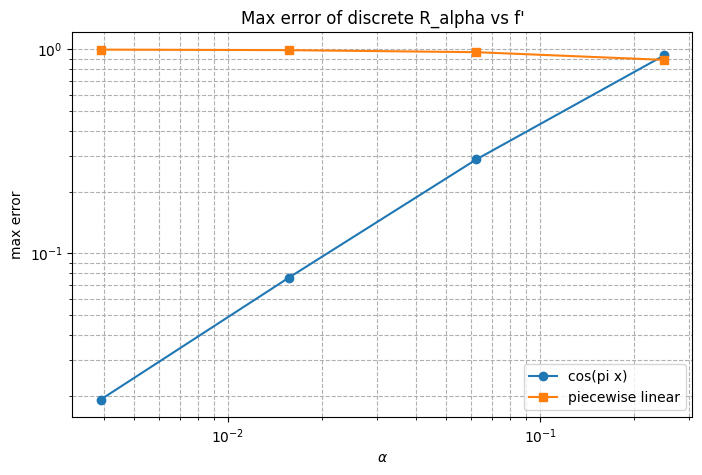

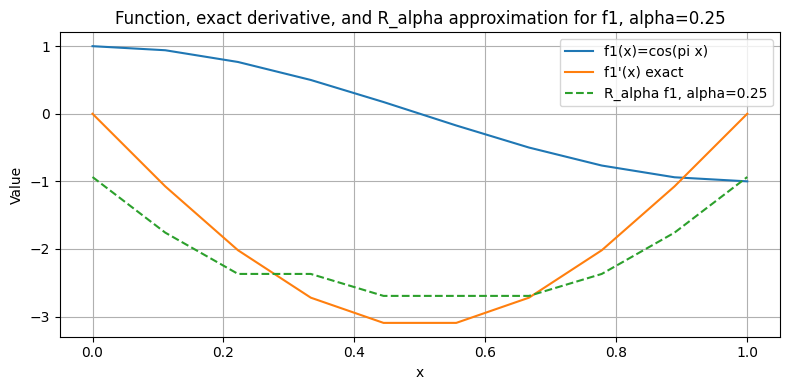

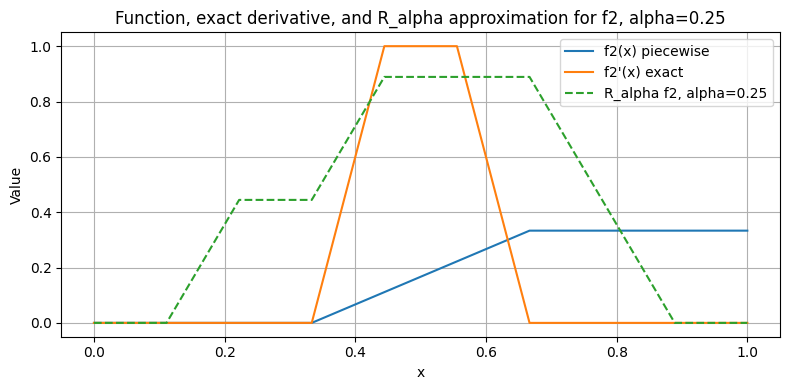

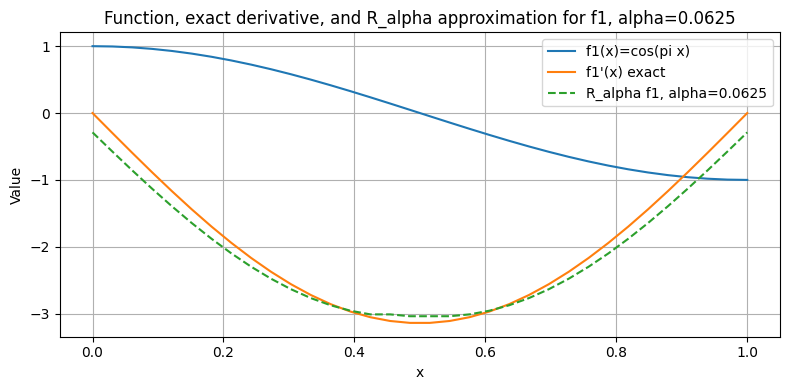

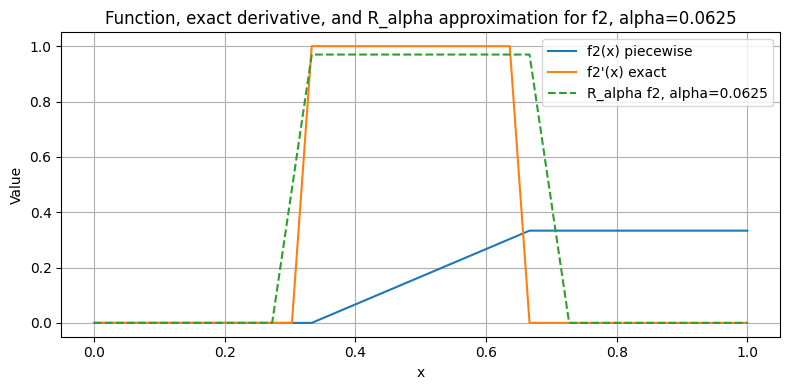

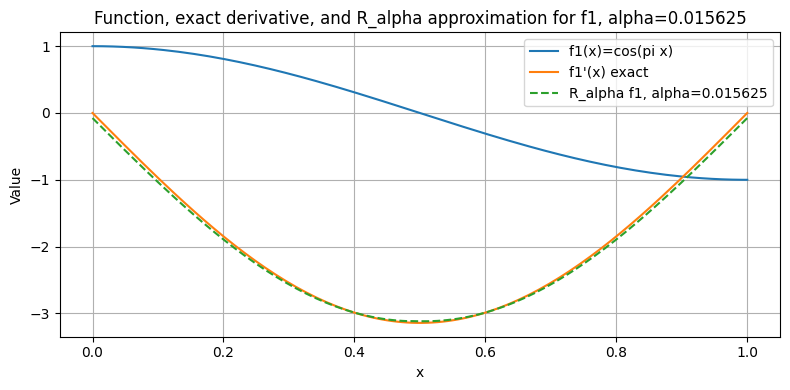

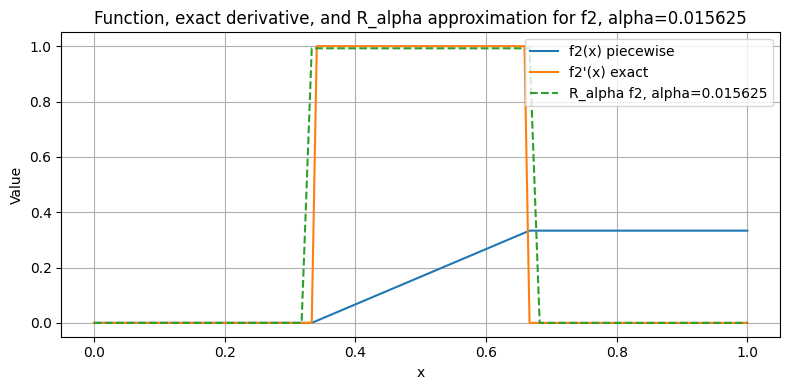

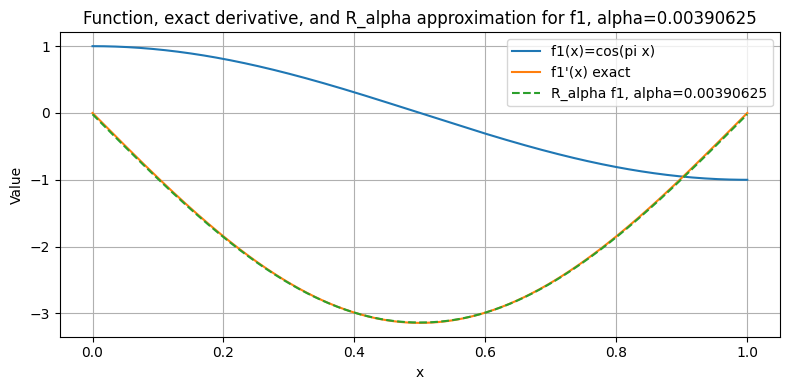

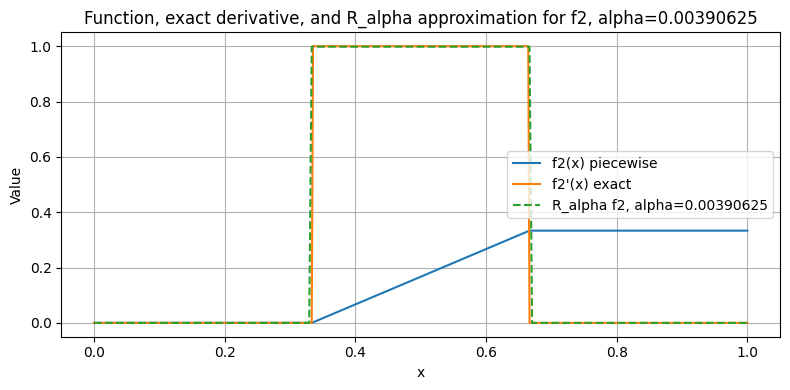

In [3]:
import numpy as np
import matplotlib.pyplot as plt


def R_alpha_discrete(f_vals: np.ndarray, alpha: float) -> np.ndarray:
    """
    Compute the discrete differential quotient R_alpha on uniform grid of 2n points:
    f_vals[k] = f(x_k) at x_k = (k)*(alpha/2), k=0,...,2n-1.
    """
    n2 = f_vals.size
    dx = alpha / 2
    idx1 = int(np.floor(((1 - alpha) / 2) / dx))
    idx2 = int(np.floor(((1 + alpha) / 2) / dx))
    shift_full = int(round(alpha / dx))      # typically 2
    shift_half = int(round((alpha/2) / dx))  # typically 1

    result = np.zeros_like(f_vals)
    # left: forward difference
    result[:idx1] = (f_vals[shift_full:idx1+shift_full] - f_vals[:idx1]) / alpha
    # middle: central difference
    result[idx1:idx2] = (
        f_vals[idx1+shift_half:idx2+shift_half]
      - f_vals[idx1-shift_half:idx2-shift_half]
    ) / alpha
    # right: backward difference
    result[idx2:] = (
        f_vals[idx2:] - f_vals[idx2-shift_full:idx2-shift_full + (n2-idx2)]
    ) / alpha
    return result


# Test functions and first derivatives:

def f1(x): return np.cos(np.pi * x)
def f1_d(x): return -np.pi * np.sin(np.pi * x)


def f2(x):
    return np.piecewise(x,
        [x < 1/3, (x >= 1/3) & (x < 2/3), x >= 2/3],
        [0, lambda x: x - 1/3, 1/3]
    )
def f2_d(x):
    # derivative zero except on (1/3,2/3)
    return np.where((x > 1/3) & (x < 2/3), 1.0, 0.0)


alphas = [2**(-k) for k in [2,4,6,8]]
errors1, errors2 = [], []

for alpha in alphas:
    n = int(1/alpha) + 1
    x = np.linspace(0, 1, 2*n)

    y1 = f1(x)
    err1 = np.max(np.abs(R_alpha_discrete(y1, alpha) - f1_d(x)))
    errors1.append(err1)

    y2 = f2(x)
    err2 = np.max(np.abs(R_alpha_discrete(y2, alpha) - f2_d(x)))
    errors2.append(err2)

# Plotting errors:
plt.figure(figsize=(8,5))
plt.loglog(alphas, errors1, 'o-', label='cos(pi x)')
plt.loglog(alphas, errors2, 's-', label='piecewise linear')
plt.xlabel(r'$\alpha$')
plt.ylabel('max error')
plt.title('Max error of discrete R_alpha vs f\'')
plt.grid(True, which='both', ls='--')
plt.legend()
plt.show()

# Additional plots: f, exact f', and R_alpha_discrete(f) for different alphas
for alpha in alphas:
    n = int(1/alpha) + 1
    x = np.linspace(0, 1, 2*n)

    # Function 1 and derivatives
    y1 = f1(x)
    y1_exact = f1_d(x)
    y1_approx = R_alpha_discrete(y1, alpha)

    plt.figure(figsize=(8,4))
    plt.plot(x, y1, label='f1(x)=cos(pi x)')
    plt.plot(x, y1_exact, '-', label='f1\'(x) exact')
    plt.plot(x, y1_approx, '--', label=f'R_alpha f1, alpha={alpha}')
    plt.xlabel('x')
    plt.ylabel('Value')
    plt.title(f'Function, exact derivative, and R_alpha approximation for f1, alpha={alpha}')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Function 2 and derivatives
    y2 = f2(x)
    y2_exact = f2_d(x)
    y2_approx = R_alpha_discrete(y2, alpha)

    plt.figure(figsize=(8,4))
    plt.plot(x, y2, label='f2(x) piecewise')
    plt.plot(x, y2_exact, '-', label='f2\'(x) exact')
    plt.plot(x, y2_approx, '--', label=f'R_alpha f2, alpha={alpha}')
    plt.xlabel('x')
    plt.ylabel('Value')
    plt.title(f'Function, exact derivative, and R_alpha approximation for f2, alpha={alpha}')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

Interpretation: We expect the max error to converge to zero for $\alpha\to 0$. This is the case for cos. Note that for the piecewise linear the max error is essentially constant to 1. This is due to discretization: there is always one point $x$ where the finite difference approximation  does align with the true derivative. In the continuum this does not matter as the error is measured in the functional $L^2$ norm and thus the difference in a single point does not contribute to the $L^2$ error.